In [2]:
# import packages
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pdz
import numpy as np
import pandas as pd

from pandas import Series, DataFrame
import Bio
from Bio import SeqIO,AlignIO

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.mixture import GaussianMixture as GMM

from sklearn.manifold import TSNE
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import time

In [107]:
# methods

def parseFasta(data):
    d = {fasta.id : str(fasta.seq) for fasta in SeqIO.parse(data, "fasta")}
    pd.DataFrame([d])
    s = pd.Series(d, name='Sequence')
    s.index.name = 'ID'
    s.reset_index()
    return pd.DataFrame(s)

def get_kmer_table(path,k_min,k_max):
    genes,gene_len = read_fasta(path)
    count_vect = CountVectorizer(analyzer='char', ngram_range=(k_min, k_max))
    X = count_vect.fit_transform(genes)
    chars = count_vect.get_feature_names()
    kmers = X.toarray()
    kmer_freq = []
    for i in range(len(genes)):
        kmer_freq.append(kmers[i] / gene_len[i])
    input = pd.DataFrame(kmer_freq, columns=chars)
    return input

def get_gene_sequences(filename):
    genes = []
    for record in SeqIO.parse(filename, "fasta"):
        genes.append(str(record.seq))
    return genes

# genes: a list of gene sequences, which can directly be generated from get_gene_sequences().
def get_gene_len(genes):
    gene_len = []

    for i in range(len(genes)):
        gene_len.append(len(genes[i]))
    return gene_len

#read single fasta file containing all the gene sequences
def read_fasta(path):
    virus = parseFasta(path)
    virus = virus.drop_duplicates(keep="last")
    genes = list(virus['Sequence'])
    gene_seq = get_gene_sequences(path)
    gene_len = get_gene_len(gene_seq)
    return gene_seq,gene_len


def get_predictions(path,k_min,k_max,num_class,cov_type,seed):
    kmer_table = get_kmer_table(path, k_min, k_max)
    gmm = GMM(n_components=num_class,covariance_type=cov_type,random_state = seed).fit(kmer_table)
    predictions = gmm.predict(kmer_table)
    return predictions

def get_predictions_semi(path,k_min,k_max,num_class,cov_type,seed,labels):
    kmer_table = get_kmer_table(path, k_min, k_max)
    finalDf = pd.concat([kmer_table, pd.Series(labels)], axis = 1)
    gmm = GMM(n_components=num_class,covariance_type=cov_type,random_state = seed)
    gmm.means_init = np.array([kmer_table[finalDf.Labels == i].mean(axis=0) for i in range(num_class)])
    gmm.fit(kmer_table)
    predictions = gmm.predict(kmer_table)
    return predictions

def cal_accuracy(labels, predictions):
    err = 0
    total_len = len(labels)
    for i in range(len(labels)):
        if (labels[i] == -1):
            total_len = total_len-1
            continue
        if (labels[i] != predictions[i]):
            err += 1
            
    return 1-err/(total_len)

In [18]:
def sammon(x, n, display = 2, maxhalves = 20, maxiter = 500, tolfun = 1e-9):

    import numpy as np 
    from scipy.spatial.distance import cdist

    D = cdist(x, x) # distance matrix
    init = 'pca' # initialization from pca

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    [UU,DD,_] = np.linalg.svd(x)
    y = UU[:,:n]*DD[:n] 
    
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]
    
def sammon_plot(y,plot_labels,path):
    x_axis = []
    y_axis = []

    for i in range(len(y)):
        x_axis.append(y[i][0])
        y_axis.append(y[i][1])

    sns.scatterplot(x_axis, y_axis, hue=plot_labels, legend='full')
    #images.append(path)
    plt.savefig(path)   
    plt.close()
    #plt.show()

In [5]:
def cal_accuracy(labels, predictions):
    err = 0
    total_len = len(labels)
    for i in range(len(labels)):
        if (labels[i] == -1):
            total_len = total_len-1
            continue
        if (labels[i] != predictions[i]):
            err += 1
            
    return 1-err/(total_len)

In [19]:
def PCA_plot(x,y,n_dim,path):
    
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=n_dim)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents,columns = ['principal component 1', 'principal component 2'])
    finalDf = pd.concat([principalDf, pd.Series(y)], axis = 1)
    finalDf.columns = ['principal component 1', 'principal component 2','target']
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [0,1]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , c = color)
    ax.legend(targets)
    #images.append(path)
    fig.savefig(path)   
    plt.close(fig)
    #plt.show()

In [20]:
def tsne_plot(x,y,path):
    tsne = TSNE()
    X_embedded = tsne.fit_transform(x)
    sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full')
    #images.append(path)
    plt.savefig(path)   
    plt.close()

In [28]:
def model_selection(path,labels,num_class,seed):
    best_accu = 0
    cov_type = ['full','diag','tied','spherical']
    k_min = [2,3,4]
    k_max = [3,4,5]
    for cov in cov_type:
        for k1 in k_min:
            for k2 in k_max:
                if (k2 >= k1):
                    prediction = get_predictions(path,k1,k2,num_class,cov,seed)
                    accu = cal_accuracy(labels,prediction)
                    if accu > best_accu: 
                        best_accu = accu
                        best_kmin = k1
                        best_kmax = k2
                        best_cov = cov
                        best_pre = prediction
    return prediction,best_kmin,best_kmax,best_cov,best_accu

# Unsupervised 

### The user can choose the values for parameters,but if some parameters are not assigned by the users, use the default values. Otherwise, replace the default values by user-assigned values.

In [82]:
path = "datasets/combined_Bat_Cat_flu.fa"
k_min = 2 #default value, change to user input if user chooses some value
k_max = 3 #default value, change to user input if user chooses some value
num_class = 2 #required for user to choose
cov_type = 'full' #default value, change to user input if user chooses some value
seed = int(time.time()) #default value, change to user input if user chooses some value
predictions1_1 = get_predictions(path,k_min,k_max,num_class,cov_type,seed)

In [83]:
predictions1_1

array([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

### Return the plot, parameter info, and predictions

In [84]:
df = get_kmer_table("datasets/combined_Bat_Cat_flu.fa",k_min,k_max)
df2 = df.drop_duplicates(keep="last")
X = df2.as_matrix(columns = df2.columns)
[y, E] = sammon(X,2)
sammon_plot(y,predictions1_1[df2.index.values],'figures/sammon_web_test1.png')
PCA_plot(df,predictions1_1,2,'figures/pca_web_test1.png')
tsne_plot(df,predictions1_1,'figures/tsne_web_test1.png')

/Users/zhiwen/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zhiwen/Applications/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


epoch = 1 : E = 0.1421706998
epoch = 2 : E = 0.1414983526
epoch = 3 : E = 0.1340482251
epoch = 4 : E = 0.1311866485
epoch = 5 : E = 0.1262983033
epoch = 6 : E = 0.1235176199
epoch = 7 : E = 0.1103771789
epoch = 8 : E = 0.1094232142
epoch = 9 : E = 0.1085228384
epoch = 10 : E = 0.1076210635
epoch = 11 : E = 0.1072554275
epoch = 12 : E = 0.0967275342
epoch = 13 : E = 0.0918998674
epoch = 14 : E = 0.0905637867
epoch = 15 : E = 0.0743733153
epoch = 16 : E = 0.0728240860
epoch = 17 : E = 0.0551435851
epoch = 18 : E = 0.0473457347
epoch = 19 : E = 0.0437824378
epoch = 20 : E = 0.0379273304
epoch = 21 : E = 0.0365097429
epoch = 22 : E = 0.0296029920
epoch = 23 : E = 0.0295920511
epoch = 24 : E = 0.0288622824
epoch = 25 : E = 0.0284943450
epoch = 26 : E = 0.0282151787
epoch = 27 : E = 0.0271957099
epoch = 28 : E = 0.0271611520
epoch = 29 : E = 0.0269738681
epoch = 30 : E = 0.0269631932
epoch = 31 : E = 0.0268259976
epoch = 32 : E = 0.0265691439
epoch = 33 : E = 0.0264497034
epoch = 34 : E = 0.

/Users/zhiwen/Applications/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


# Semi-supervised

In [110]:
path = "datasets/combined_Bat_Cat_flu.fa"
k_min = 2 #default value, change to user input if user chooses some value
k_max = 3 #default value, change to user input if user chooses some value
num_class = 2 #required for user to choose
cov_type = 'full' #default value, change to user input if user chooses some value
seed = int(time.time()) #default value, change to user input if user chooses some value
labels = pd.read_csv('datasets/labels_fifty_percent.csv')#change to user input
labels = pd.Series(labels['Labels'])

predictions2_1 = get_predictions_semi(path,k_min,k_max,num_class,cov_type,seed,labels)

In [111]:
predictions2_1

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0])

### Return the plot, parameter info

In [112]:
df = get_kmer_table("datasets/combined_Bat_Cat_flu.fa",k_min,k_max)
df2 = df.drop_duplicates(keep="last")
X = df2.as_matrix(columns = df2.columns)
[y, E] = sammon(X,2)
sammon_plot(y,predictions1_1[df2.index.values],'figures/sammon_web_test2.png')
PCA_plot(df,predictions2_1,2,'figures/pca_web_test2.png')
tsne_plot(df,predictions2_1,'figures/tsne_web_test2.png')

/Users/zhiwen/Applications/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zhiwen/Applications/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


epoch = 1 : E = 0.1421706998
epoch = 2 : E = 0.1414983526
epoch = 3 : E = 0.1340482251
epoch = 4 : E = 0.1311866485
epoch = 5 : E = 0.1262983033
epoch = 6 : E = 0.1235176199
epoch = 7 : E = 0.1103771789
epoch = 8 : E = 0.1094232142
epoch = 9 : E = 0.1085228384
epoch = 10 : E = 0.1076210635
epoch = 11 : E = 0.1072554275
epoch = 12 : E = 0.0967275342
epoch = 13 : E = 0.0918998674
epoch = 14 : E = 0.0905637867
epoch = 15 : E = 0.0743733153
epoch = 16 : E = 0.0728240860
epoch = 17 : E = 0.0551435851
epoch = 18 : E = 0.0473457347
epoch = 19 : E = 0.0437824378
epoch = 20 : E = 0.0379273304
epoch = 21 : E = 0.0365097429
epoch = 22 : E = 0.0296029920
epoch = 23 : E = 0.0295920511
epoch = 24 : E = 0.0288622824
epoch = 25 : E = 0.0284943450
epoch = 26 : E = 0.0282151787
epoch = 27 : E = 0.0271957099
epoch = 28 : E = 0.0271611520
epoch = 29 : E = 0.0269738681
epoch = 30 : E = 0.0269631932
epoch = 31 : E = 0.0268259976
epoch = 32 : E = 0.0265691439
epoch = 33 : E = 0.0264497034
epoch = 34 : E = 0.

/Users/zhiwen/Applications/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


# Plot for the illustration of covariance type

In [48]:
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = matplotlib.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')



In [58]:
df = get_kmer_table("datasets/combined_Bat_Cat_flu.fa",k_min,k_max)
df['target']=pd.Series(predictions1_1)

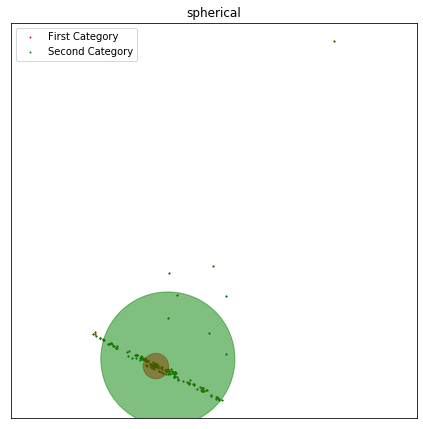

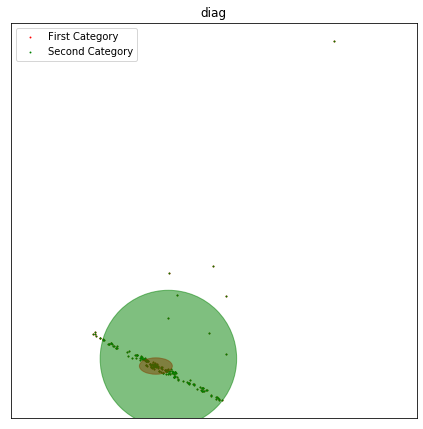

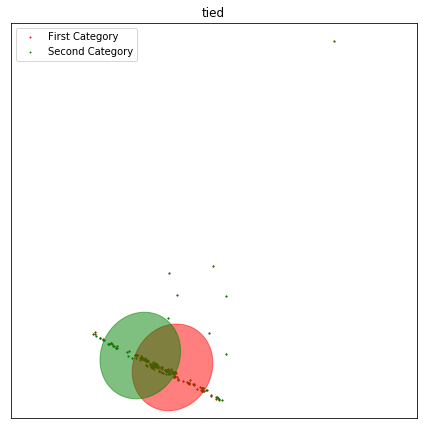

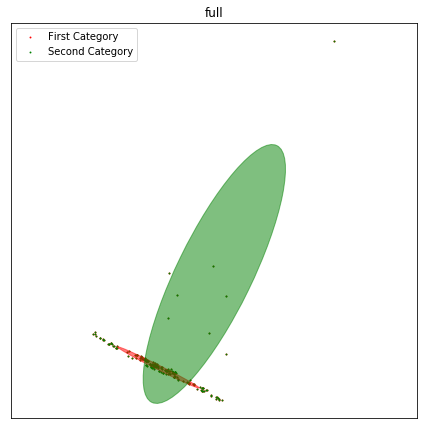

In [85]:
num_class = 2
colors = ['red', 'green']

x = StandardScaler().fit_transform(df)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.Series(predictions1_1)], axis = 1)
finalDf.columns = ['principal component 1', 'principal component 2','target']

# Try GMMs using different types of covariances.
estimators = {cov_type: GMM(n_components=num_class,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

for index, (name, estimator) in enumerate(estimators.items()):
    estimator.means_init = np.array([principalDf[finalDf.target == i].mean(axis=0)
                                    for i in range(num_class)])

    estimator.fit(principalDf)
    n_estimators = len(estimators)
    
    plt.figure(figsize=(8 * n_estimators // 2, 16))

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], s=0.8, color=color,
                    label=finalDf.target)
        
    plt.xticks(())
    plt.yticks(())
    plt.title(name)
    plt.legend(['First Category', 'Second Category'])